## Group Member
### Abha Chaudhary
### Amit Luhar
### Hozefa Lakdawala

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip drive/MyDrive/datasets/archive.zip -d data

### The usual, Imports

In [1]:
import os, csv
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as F
torch.cuda.empty_cache()
import cv2
import numpy as np

### Displaying the graph

In [2]:
def plot_the_graph(train_losses,val_losses,train_accuracies,val_accuracies,num_epochs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs+1), train_losses, label='Train')
    plt.plot(range(1, num_epochs+1), val_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', color='magenta')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Training Loop

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data,1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train
        val_loss = val_loss / len(val_loader.dataset)
        val_acc = correct / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    return train_losses,val_losses,train_accuracies,val_accuracies

### Testing Loop

In [4]:
def test_model(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = correct / total
    print(f"Test Accuracy: {test_accuracy:.4f}")

### Loading and PreProcessing the Data

In [5]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

In [ ]:
train_path = "data/train"
test_path = "data/test"

train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

In [ ]:
batch_size = 256
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
# train_gpu_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in train_loader]
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
# val_gpu_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in val_loader]
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# test_gpu_loader = [(inputs.to(device), labels.to(device)) for inputs, labels in test_loader]
print(device)

In [ ]:
count = 0
for input,lab in train_loader:
    count+=1
    if(count > 4):
        break

# count = 0
# for input,lab in train_gpu_loader:
#     print(input.device)
#     count+=1
#     if(count > 4):
#         break

### Show Loaded Data

In [ ]:
classes = os.listdir(train_path)
fig, axs = plt.subplots(1, 7, figsize=(15, 5))
for i, class_name in enumerate(classes):
    img_path = os.path.join(train_path, class_name, os.listdir(os.path.join(train_path, class_name))[0])
    img = Image.open(img_path)
    axs[i].imshow(img, cmap='gray')
    axs[i].set_title(class_name)
    axs[i].axis('off')
plt.show()

### Creating the SimpleCNN Model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7,dropout=False):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, padding=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 3 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, num_classes)
        if dropout:
            self.dropout = torch.nn.Dropout(0.5)
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = torch.flatten(x,1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleCNN(dropout=False).to(device)
print(model)
summary(model,(1,48,48))

### Training Simple CNN model

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 25
train_losses,val_losses,train_accuracies,val_accuracies = train_model(model, train_loader, val_loader, criterion,optimizer, num_epochs=n_epochs)

### Displaying the Graph

In [ ]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epochs)

### Evaluating the simple cnn model on Test dataset

In [ ]:
test_model(model, test_loader)

### Saving the Model

In [ ]:
model_path = "simple_cnn_model.pth"
torch.save(model.state_dict(),model_path)

### Training the Model with droupouts

In [ ]:
model = SimpleCNN(dropout=True).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
n_epochs = 25
train_losses,val_losses,train_accuracies,val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer_adam, num_epochs=n_epochs)

### Evaluating the cnn model with dropout on Test dataset

In [ ]:
test_model(model, test_loader)

### Displaying the Graph with adam and dropout

In [ ]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epochs)

### Saving the Model with dropouts

In [ ]:
model_path = "cnn_model_with_dropout.pth"
torch.save(model.state_dict(),model_path)

### Training the Model with droupouts and weight decay

In [ ]:
model = SimpleCNN(dropout=True).to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.0005)
n_epochs = 25
train_losses,val_losses,train_accuracies,val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer_adam, num_epochs=n_epochs)

In [ ]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epochs)

### Evaluating the cnn model with dropout on Test dataset

In [ ]:
test_model(model, test_loader)

### Displaying the Graph with adam

In [ ]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epochs)

### Saving the Model with dropouts

In [ ]:
model_path = "cnn_model_with_dropout.pth"
torch.save(model.state_dict(),model_path)

### Training the Model with sgd optimizer

In [ ]:
model = SimpleCNN().to(device)
print(model)
criterion = torch.nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
n_epochs = 25
train_losses,val_losses,train_accuracies,val_accuracies = train_model(model, train_loader, val_loader, criterion,optimizer_sgd, num_epochs=n_epochs)

### Displaying the Graph with SGD

In [ ]:
plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epochs)

### Pre-trained Models

In [12]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
train_path = "data/train"
test_path = "data/test"

train_dataset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)

train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
batch_size = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(device)

cuda:0


In [13]:

num_classes = len(os.listdir(train_path))

resnet18 = torchvision.models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

mobilenet = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, num_classes)

squeezeNet = torchvision.models.squeezenet1_0(pretrained=True)
squeezeNet.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
squeezeNet.num_classes = num_classes

/usr/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  war

### MobileNet V2

Epoch 1/15, Train Loss: 1.2506, Val Loss: 1.2569, Train Acc: 0.5285, Val Acc: 0.5249
Epoch 2/15, Train Loss: 1.1040, Val Loss: 1.1970, Train Acc: 0.5845, Val Acc: 0.5437
Epoch 3/15, Train Loss: 1.0548, Val Loss: 1.1456, Train Acc: 0.6064, Val Acc: 0.5583
Epoch 4/15, Train Loss: 1.0413, Val Loss: 1.1952, Train Acc: 0.6146, Val Acc: 0.5792
Epoch 5/15, Train Loss: 1.0141, Val Loss: 1.1533, Train Acc: 0.6210, Val Acc: 0.5580
Epoch 6/15, Train Loss: 0.9932, Val Loss: 1.0824, Train Acc: 0.6305, Val Acc: 0.5925
Epoch 7/15, Train Loss: 0.9779, Val Loss: 1.0872, Train Acc: 0.6374, Val Acc: 0.5998
Epoch 8/15, Train Loss: 0.9604, Val Loss: 1.1116, Train Acc: 0.6446, Val Acc: 0.5817
Epoch 9/15, Train Loss: 0.9495, Val Loss: 1.0900, Train Acc: 0.6478, Val Acc: 0.5810
Epoch 10/15, Train Loss: 0.9299, Val Loss: 1.1985, Train Acc: 0.6540, Val Acc: 0.5559
Epoch 11/15, Train Loss: 0.9259, Val Loss: 1.0615, Train Acc: 0.6572, Val Acc: 0.5998
Epoch 12/15, Train Loss: 0.9022, Val Loss: 1.1267, Train Acc: 0

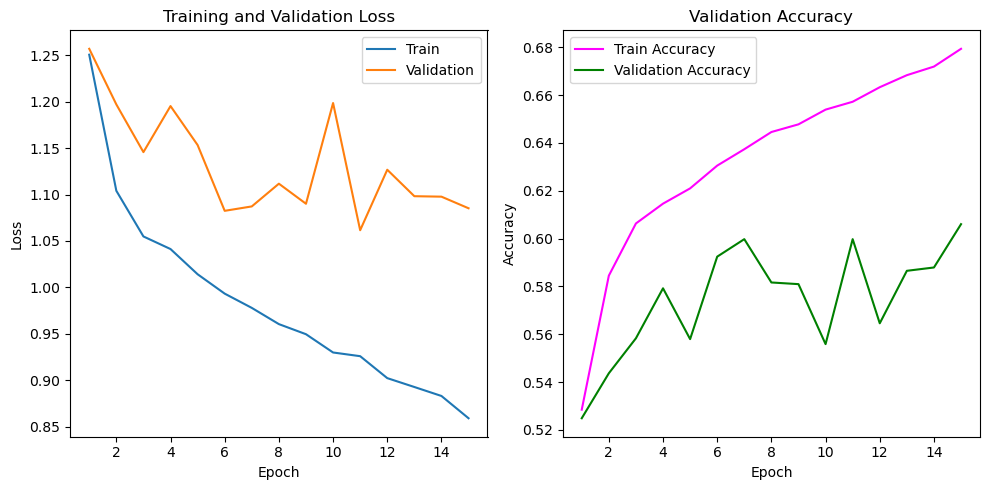

Test Accuracy: 0.6121


In [14]:
model = mobilenet
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00125, weight_decay=1e-3)
n_epoch = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=n_epoch
)

plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epoch)
test_model(model, test_loader)

In [17]:
torch.save(model.state_dict(),'/home/dedsec995/hci/hci_prj1/model.pth')

### SqeezeNet

In [ ]:
model = squeezeNet
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00125)
n_epoch = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=n_epoch
)

plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epoch)
test_model(model, test_loader)

### ResNet 18

In [ ]:
model = resnet18
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00125)
n_epoch = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=n_epoch 
)

plot_the_graph(train_losses=train_losses,val_losses=val_losses,train_accuracies=train_accuracies,val_accuracies=val_accuracies,num_epochs=n_epoch)
test_model(model, test_loader)

### Implementing OpenCV to run inference on Video

In [18]:
def preprocess_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
    img_resized = cv2.resize(img_rgb, (224, 224))
    img_normalized = img_resized / 255.0
    img_tensor = np.expand_dims(img_normalized, axis=0)
    img_tensor = torch.tensor(img_tensor, dtype=torch.float32).permute(0, 3, 1, 2)
    return img_tensor

In [19]:
model = mobilenet
# model = CustomMobileNet()
model.load_state_dict(torch.load("model.pth")) # Train the model above and then only run this code. As we are not allowed to give models, only this notebook is to be submitted
model.to(device)
model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [20]:
def infer_frame(frame):
    input_tensor = preprocess_image(frame)
    input_tensor = torch.tensor(input_tensor, dtype=torch.float32)
    input_tensor = input_tensor.to(device)
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
    return predicted.item()

In [28]:
video_path = 'demo.mp4' # Change it according to the sample file you will use
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Unable to open video file")
    exit()


face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame_width, frame_height))

while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_frame, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        face_roi = frame[y:y+h, x:x+w]
        predicted_class = infer_frame(face_roi)
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        emotion_label = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
        cv2.putText(frame, emotion_label[predicted_class], (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        
    out.write(frame)
    cv2.imshow('Emotion Detection', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
cap.release()
out.release()
cv2.destroyAllWindows()

/tmp/ipykernel_4825/3833247737.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_tensor = torch.tensor(input_tensor, dtype=torch.float32)


Since you have reached here, Kudos!! For any further questions, you can reach out to us on

aluhar1@binghamton.edu

hlakada1@binghamton.edu

achaud15@binghamton.edu